<a href="https://colab.research.google.com/github/vnprr/spotify_predictor/blob/main/songs_spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Programowanie/SpotifyPredicterRefactored")

In [ ]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import string
from joblib import dump
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tqdm import tqdm

In [ ]:
from songs_spotify import load_artists, load_spotify_songs, load_joined_songs, get_Xy, train_test_split

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Przygotowanie danych

## Artists last_fm

In [ ]:
# load last fm data
artists = load_artists()

artists

,artist_mb,country_mb
0,coldplay,United Kingdom
1,radiohead,United Kingdom
2,red hot chili peppers,United States
3,rihanna,United States
4,eminem,United States
...,...,...
1466078,정은지,South Korea
1466079,남태현,South Korea
1466080,헤일로,South Korea
1466081,서현진,South Korea


## Spotify songs

In [ ]:
# load spotify data
spotify_songs = load_spotify_songs()

spotify_songs

,track_artist,track_popularity,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_album_release_year,track_album_release_month
0,ed sheeran,66,pop remix,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754,2019,6.0
1,maroon 5,67,pop remix,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600,2019,12.0
2,zara larsson,70,pop remix,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616,2019,7.0
3,chainsmokers,60,pop remix,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093,2019,7.0
4,lewis capaldi,69,pop remix,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052,2019,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,lush simon,42,♥ edm love 2020,edm,progressive electro house,0.428,0.922,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375,2014,4.0
32829,tegan sara,20,♥ edm love 2020,edm,progressive electro house,0.522,0.786,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120,2013,3.0
32830,starkillers,14,♥ edm love 2020,edm,progressive electro house,0.529,0.821,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112,2014,4.0
32831,mat zo,15,♥ edm love 2020,edm,progressive electro house,0.626,0.888,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432,2014,1.0


##Join sets

In [ ]:
songs_joined = load_joined_songs(spotify_songs, artists)

## Compute all songs xy

In [ ]:
X, y = get_Xy(songs_joined)

##Train/Test Split

In [ ]:
#XY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1337)

##Training

##Ridge

In [ ]:
ridge = RidgeCV(alphas=[0.001, 0.0001, 0.01, 1, 0.1])
ridge.fit(X_train, y_train)

RidgeCV(alphas=[0.001, 0.0001, 0.01, 1, 0.1])

In [ ]:
ridge.score(X_train, y_train)

0.25388157378324516

In [ ]:
ridge.score(X_test, y_test)

0.2532727577318854

##SVR

In [ ]:
#model testowany, zajmuje dużo czasu, słaby score

#parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, 1, 10]}
#svr = SVR()
#model = GridSearchCV(svr, parameters, n_jobs = -1, cv = 3, verbose=True)

#optymalizacja
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1]}
svr = SVR()
model = GridSearchCV(svr, parameters, n_jobs=2, cv=3, verbose=True)


model.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


KeyboardInterrupt: 

In [ ]:
model.score(X_train, y_train)

In [ ]:
model.score(X_test, y_test)

##K-NN

In [ ]:
parameters = {'n_neighbors': (3, 5, 10, 15, 25, 50)}
knn = KNeighborsRegressor()
model_knn = GridSearchCV(knn, parameters, n_jobs = -1, cv = 3, verbose=True)
model_knn.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

In [ ]:
model_knn.score(X_train, y_train)

NameError: name 'model_knn' is not defined

In [ ]:
model_knn.score(X_test, y_test)

##random forest

In [ ]:
# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1337)

# Utworzenie modelu RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=42)

# Trenowanie modelu na danych treningowych
rf_model.fit(X_train, y_train)

# Przewidywanie na danych testowych
y_pred = rf_model.predict(X_test)



KeyboardInterrupt: 

In [ ]:
rf_model.score(X_train, y_train)

0.6592811276140996

In [ ]:
rf_model.score(X_test, y_test)

0.606660919571677

In [ ]:
plt.figure(figsize = (7, 7))

# draw random forest
sns.kdeplot(x=y_test, y=y_pred)
sns.regplot(x=y_test, y=y_pred, scatter=False)

NameError: name 'y_pred' is not defined

<Figure size 700x700 with 0 Axes>

##random boosting (best score)

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)

# Train model
gb_model.fit(X_train, y_train)

# Predict on X_test
y_pred_gb = gb_model.predict(X_test)



In [ ]:
gb_model.score(X_train, y_train)

0.83284685347554

In [ ]:
gb_model.score(X_test, y_test)

0.7227388421411312

<Axes: xlabel='track_popularity'>

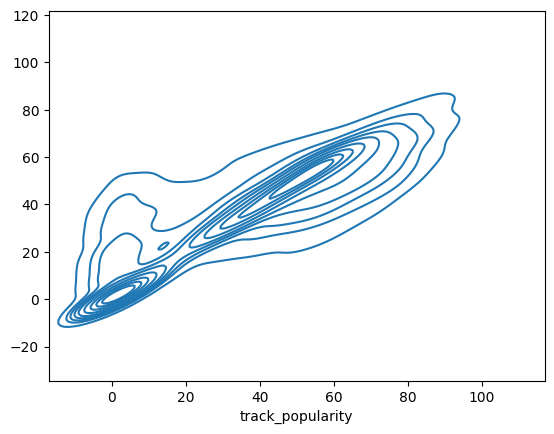

In [ ]:
sns.kdeplot(x=y_test, y=y_pred_gb)

In [ ]:
gbmodel_path = "models/gb_model.joblib"
os.makedirs(os.path.dirname(gbmodel_path), exist_ok = True)
dump(gb_model, gbmodel_path)

['models/gb_model.joblib']

## Neural Networks

In [ ]:
# architecture
nn_model = Sequential()
nn_model.add(Dense(256, activation="relu", input_shape=(X_train.shape[1],)))
nn_model.add(Dense(128, activation="relu"))
# ^ #128, 128, 50: tr 0.5822491450527092, 0.5244461518283765
nn_model.add(Dense(128, activation="relu"))
# ^ #128, 128, 128, 50: tr 0.5964326981226203 te 0.541574869925696
#nn_model.add(Dense(128, activation="relu"))
# ^ 128, 128, 128, 128, 50: tr 0.6420181327529579, te 0.5339284515859302
nn_model.add(Dense(1))

# compilation
nn_model.compile(optimizer="rmsprop", loss="mean_absolute_error")

# training
history = nn_model.fit(x=X_train.values, y=y_train.values, epochs=50, batch_size=32, validation_split=0.2, verbose=True)



Epoch 1/50
900/900 [==============================] - 9s 8ms/step - loss: 19.9767 - val_loss: 18.9987
Epoch 2/50
900/900 [==============================] - 5s 5ms/step - loss: 17.8153 - val_loss: 17.2603
Epoch 3/50
900/900 [==============================] - 2s 3ms/step - loss: 16.8002 - val_loss: 17.8189
Epoch 4/50
900/900 [==============================] - 3s 3ms/step - loss: 15.8434 - val_loss: 15.3283
Epoch 5/50
900/900 [==============================] - 3s 4ms/step - loss: 14.9767 - val_loss: 14.7269
Epoch 6/50
900/900 [==============================] - 3s 3ms/step - loss: 14.1754 - val_loss: 13.7022
Epoch 7/50
900/900 [==============================] - 2s 3ms/step - loss: 13.6650 - val_loss: 13.3620
Epoch 8/50
900/900 [==============================] - 2s 2ms/step - loss: 13.3131 - val_loss: 12.5740
Epoch 9/50
900/900 [==============================] - 3s 3ms/step - loss: 12.9735 - val_loss: 14.0697
Epoch 10/50
900/900 [==============================] - 3s 4ms/step - loss: 12.7110

In [ ]:
#rate
y_pred = nn_model.predict(X_test)
y_train_pred = nn_model.predict(X_train)

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_pred))
print(nn_model.summary())

1125/1125 [==============================] - 2s 2ms/step
0.6292330058188349
0.5478177461288882
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               2432      
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 35585 (139.00 KB)
Trainable params: 35585 (139.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


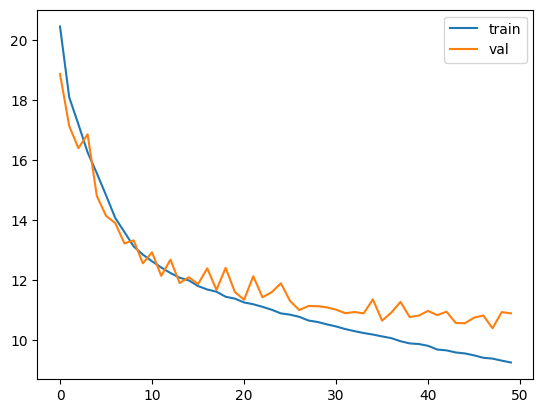

In [ ]:
#overfitting - jak spada walidacyjny to testowy też spada razem z nim, tu jest lekko
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val")

plt.legend()

<Axes: xlabel='track_popularity'>

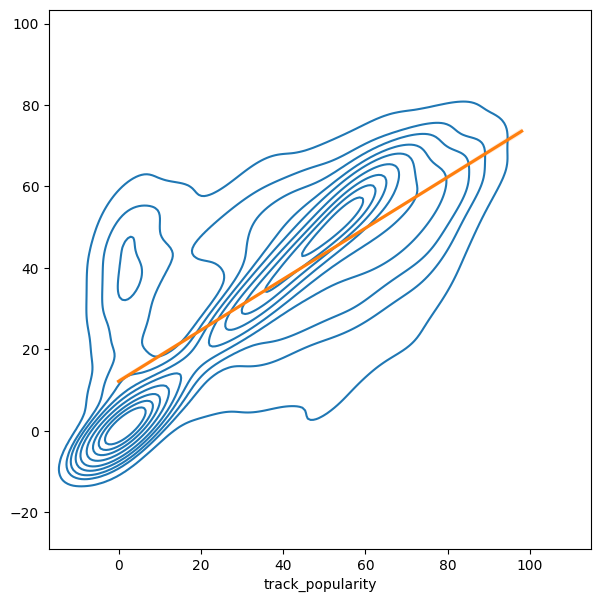

In [ ]:
plt.figure(figsize = (7, 7))
sns.kdeplot(x=y_test, y=y_pred.flatten())
sns.regplot(x=y_test, y=y_pred, scatter=False)